# Analysis of scEU-seq data

This tutorial includes: (1) deriving cell fates on the relative position along the cell cycle of the Geminin-GFP and the Cdt1- RFP signals, and (2) estimating pseudotime.

Below is the case study for metabolic labeling data (scEU-seq) in pulse phase [Battich et al.](https://www.science.org/doi/10.1126/science.aax3072?url_ver=Z39.88-2003&rfr_id=ori:rid:crossref.org&rfr_dat=cr_pub%20%200pubmed)

## Import packages

In [1]:
import os
import sys
import glob
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import sys
import celldancer as cd
import celldancer.cdplt as cdplt
from celldancer.cdplt import colormap

## Load velocity estimation result

To project the prediction of RNA velocity to the cell cycle position of the Geminin-GFP and the Cdt1- RFP signals, the predicted genes can be downloaded from [RPE1_cellDancer_estimation.csv.zip](https://drive.google.com/file/d/11KaZft1cWPHoyi0qzGh-8U68oDnjqlao/view?usp=sharing).

In [2]:
cellDancer_df_path='your_path/RPE1_cellDancer_estimation.csv'
cellDancer_df=pd.read_csv(cellDancer_df_path)
cellDancer_df

,cellIndex,gene_name,unsplice,splice,unsplice_predict,splice_predict,alpha,beta,gamma,loss,cellID,clusters,embedding1,embedding2
0,0,KIF23,1.539286,1.533211,1.185260,1.570541,0.236054,1.282048,1.388728,0.059623,Cell_02365,230.0,19.007996,12.118379
1,1,KIF23,0.041731,0.306836,0.097005,0.219471,0.080366,1.292522,1.275542,0.059623,Cell_02366,66.0,3.941931,13.829129
2,2,KIF23,0.550383,0.494205,0.487792,0.534964,0.151403,1.249363,1.289527,0.059623,Cell_02367,109.0,7.383702,15.619773
3,3,KIF23,0.372354,0.384467,0.353254,0.397097,0.130004,1.258654,1.278304,0.059623,Cell_02368,85.0,4.190689,16.004624
4,4,KIF23,0.860190,0.860697,0.713405,0.888235,0.183317,1.258010,1.325552,0.059623,Cell_02369,177.0,15.290248,16.799143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201823,3053,FBXL20,0.236709,0.147102,0.191476,0.200384,0.216331,0.170006,0.158425,0.060008,Cell_05418,40.0,4.102981,10.934589
201824,3054,FBXL20,0.119396,0.260186,0.100036,0.241114,0.149140,0.178844,0.165407,0.060008,Cell_05419,98.0,5.660549,16.980349
201825,3055,FBXL20,0.079438,0.168059,0.073876,0.156283,0.148283,0.174139,0.163663,0.060008,Cell_05420,176.0,15.388919,17.333243
201826,3056,FBXL20,0.167772,0.195752,0.138234,0.211571,0.180634,0.173768,0.161641,0.060008,Cell_05421,91.0,2.915525,18.054328


## Visualize the phase portraits

We visualize the phase portrait of genes with ```cdplt.scatter_gene()```.

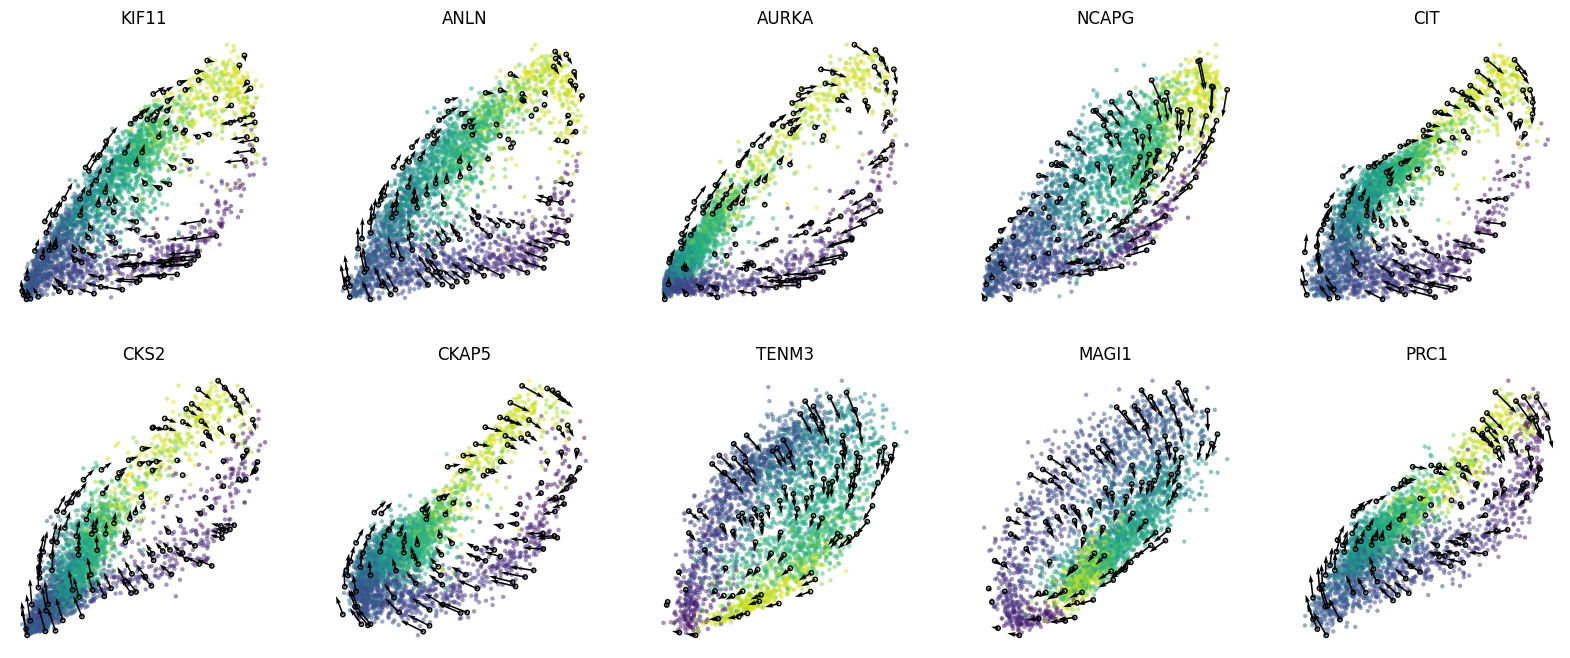

In [3]:
gene_list=['KIF11','ANLN','AURKA','NCAPG','CIT','CKS2','CKAP5','TENM3','MAGI1','PRC1']

#plot
ncols=5
height=math.ceil(len(gene_list)/ncols)*4
fig = plt.figure(figsize=(20,height))

for i in range(len(gene_list)):
    ax = fig.add_subplot(math.ceil(len(gene_list)/ncols), ncols, i+1)
    cdplt.scatter_gene(
        ax=ax,
        x='splice',
        y='unsplice',
        cellDancer_df=cellDancer_df,
        custom_xlim=None,
        custom_ylim=None,
        colors='clusters',
        alpha=0.5,
        s = 10,
        velocity=True,
        gene=gene_list[i])

    ax.set_title(gene_list[i])
    ax.axis('off')

plt.show()

## Project the RNA velocity onto the embedding space

We calculate the projection of RNA velocity on the relative positions in the cell cycle based on the Geminin-GFP and the Cdt1- RFP signals.

In [4]:
cellDancer_df=cd.compute_cell_velocity(cellDancer_df=cellDancer_df,
                                       projection_neighbor_choice='gene',
                                       expression_scale=None,
                                       projection_neighbor_size=200,
                                       speed_up=None
                                       )

## Estimate pseudotime

We estimate the pseudotime with ```cd.pseudo_time()```.

In [5]:
%%capture
import random
# set parameters
dt = 0.05
t_total = {dt:int(10/dt)}
n_repeats = 10

# estimate pseudotime
cellDancer_df = cd.pseudo_time(cellDancer_df=cellDancer_df,
                               grid=(30,30),
                               dt=dt,
                               t_total=t_total[dt],
                               n_repeats=n_repeats,
                               speed_up=(100,100),
                               n_paths = 3,
                               psrng_seeds_diffusion=[i for i in range(n_repeats)],
                               n_jobs=8)

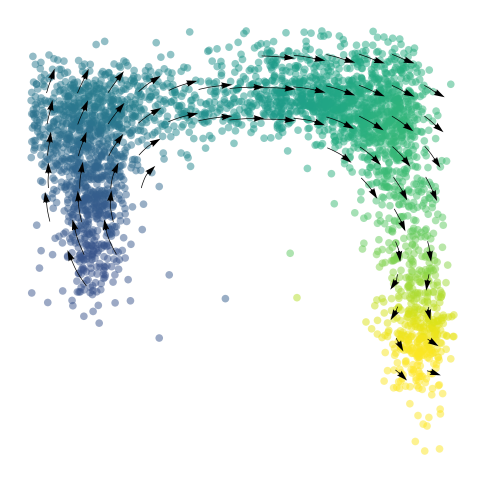

In [6]:
# plot pseudotime
# adjust embedding ranges to ~ (0, 20) for visualization
cellDancer_df_plt=cellDancer_df.copy()
cellDancer_df_plt.loc[:, 'embedding1'] = cellDancer_df_plt['embedding1']/cellDancer_df_plt['embedding1'].max()*20
cellDancer_df_plt.loc[:, 'embedding2'] = cellDancer_df_plt['embedding2']/cellDancer_df_plt['embedding2'].max()*20

fig, ax = plt.subplots(figsize=(6,6))
im = cdplt.scatter_cell(ax,cellDancer_df_plt,
                        colors='pseudotime',
                        alpha=0.5,
                        s=30,
                        velocity=True,
                        legend='off',
                        min_mass=25,
                        arrow_grid=(15,15),
                        vmin=-0.35,
                        vmax=1,
                        colorbar='off')
ax.axis('off')
plt.show()